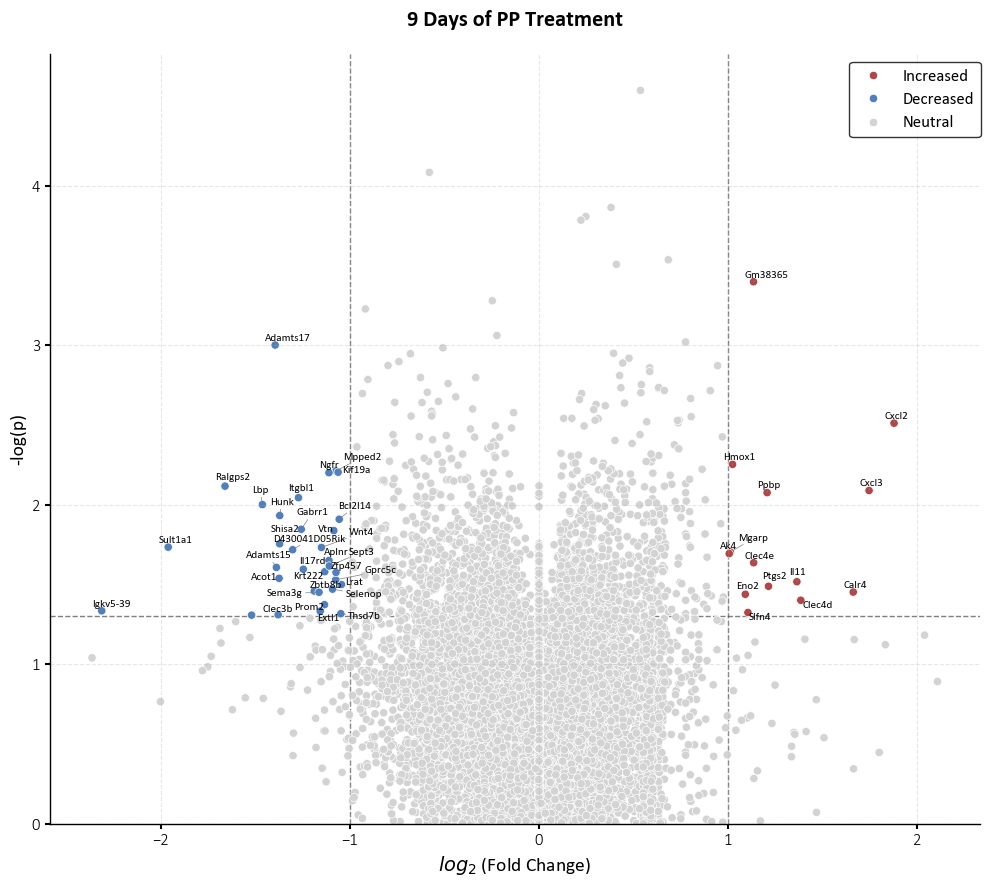

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

plt.rcParams['font.family'] = 'Calibri'  # Set default font for plots

# Load tab-separated input data
df = pd.read_csv('summary_table_supervised_PT_PP_PT_CTRL_and_PT_PP_PT_CTRL_long_7_9_12_230524.txt', sep='\t')

# Drop unused columns
df.drop(columns=['Chr', 'Start', 'End', 'GeneLength'], inplace=True)

# Compute -log10(p-value) and log2(fold change) for day 9 comparison
df['-log10(p)9'] = -np.log10(df['ttest_unpaired_p_PT_PP_PT_CTRL_long_9'])
df['log2(FC)9'] = np.log2(df['folds_median_PT_PP_PT_CTRL_long_9'])

# Categorize genes based on significance and fold change
def assign_regulation(row):
    if row['-log10(p)9'] > 1.3:  # p < 0.05
        if row['log2(FC)9'] >= 1:
            return 'Increased'
        elif row['log2(FC)9'] <= -1:
            return 'Decreased'
    return 'Neutral'

df['Regulation'] = df.apply(assign_regulation, axis=1)

# Filter genes by regulation category
upregulated_genes = df[df['Regulation'] == 'Increased'][['GeneName', 'log2(FC)9', '-log10(p)9']]
downregulated_genes = df[df['Regulation'] == 'Decreased'][['GeneName', 'log2(FC)9', '-log10(p)9']]

# Plot setup
plt.figure(figsize=(12, 10))
ax = sns.scatterplot(
    data=df,
    x='log2(FC)9',
    y='-log10(p)9',
    hue='Regulation',
    hue_order=['Increased', 'Decreased', 'Neutral'],
    palette=['#AF4647', '#517FBC', 'lightgray'],
    sizes=(40, 400)
)

ax.set_ylim(0, None)  # Ensure y-axis starts at 0

# Significance cutoffs
ax.axhline(1.3, zorder=0, c='k', lw=1, ls='--', alpha=0.5)
ax.axvline(1, zorder=0, c='k', lw=1, ls='--', alpha=0.5)
ax.axvline(-1, zorder=0, c='k', lw=1, ls='--', alpha=0.5)

# Highlight top significant genes for labeling
top_increased = df[df['Regulation'] == 'Increased'].nlargest(15, '-log10(p)9')
top_decreased = df[df['Regulation'] == 'Decreased'].nlargest(32, '-log10(p)9')
highlight_genes = pd.concat([top_increased, top_decreased])

# Annotate genes with names (prevent overlapping)
texts = []
for i, row in highlight_genes.iterrows():
    texts.append(ax.text(row['log2(FC)9'], row['-log10(p)9'],
                         row['GeneName'], fontsize=8, color='black',
                         ha='center', va='bottom'))

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
    ax=ax
)

# Customize legend
plt.legend(
    loc=1,
    bbox_to_anchor=(1.01, 1),
    frameon=True,
    facecolor='white',
    edgecolor='black',
    fontsize=12
)

# Tweak plot aesthetics
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(width=1.5)
plt.xticks(size=12, weight='light')
plt.yticks(size=12, weight='light')

plt.xlabel("$log_{2}$ (Fold Change)", size=14)
plt.ylabel("-log(p)", size=14)
ax.set_title('9 Days of PP Treatment', fontsize=16, fontweight='bold', pad=20)

# Uncomment below to save figure
# plt.savefig('Volcano_plot_PT_day9.png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()
